In [1]:
# 参考
# https://jeremy9959.net/Blog/StanMixture/

In [2]:
import numpy as np
from numpy.random import *
import pystan
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from scipy.special import expit

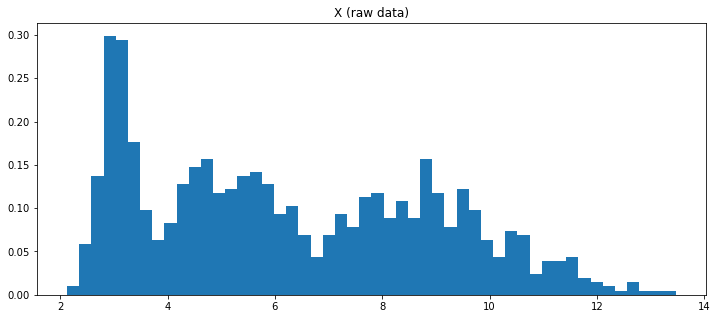

In [3]:
K = 3

A_mu = 3
B_mu = 5
C_mu = 9

A_sigma = 0.3
B_sigma = 1
C_sigma = 1.6

A_num = 200
B_num = 300
C_num = 400
total = A_num + B_num + C_num

A = np.random.normal(loc = A_mu, scale = A_sigma, size = A_num)
B = np.random.normal(loc = B_mu, scale = B_sigma, size = B_num)
C = np.random.normal(loc = C_mu, scale = C_sigma, size = C_num)

X = np.concatenate([A, B, C])

plt.figure(figsize=(12, 5))
plt.title('X (raw data)')
plt.hist(X, bins = 50, density=True)
plt.show()

In [4]:
df = pd.DataFrame({
    'X': X,})

df.head(10)

,X
0,3.248857
1,2.708166
2,2.956949
3,3.173450
4,2.953696
5,2.181367
6,3.501336
7,3.197213
8,3.663341
9,3.327575


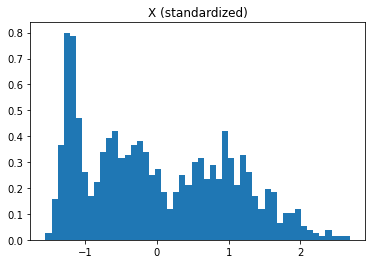

In [5]:
from sklearn.preprocessing import StandardScaler
dfs = StandardScaler().fit_transform(df)
plt.title('X (standardized)')
ax = plt.hist(dfs[:,0], bins=50, density=True)

In [6]:
stan_data={'N':dfs.shape[0],'y':dfs[:,0], 'K':K}

In [7]:
# dfsは正規化されたdfであり、以下のmodelブロック事前分布は正規分布を基にした

stan_code="""
data {
    int<lower = 0> N;
    vector[N] y;
    int<lower = 0> K;
}

parameters {
    ordered[K] mu;
    real<lower=0> sigma[K];
    simplex[K] pi;
}

model {         
    real lp[K];
    sigma ~ normal(0, 1);
    mu ~ normal(0, 1);
    pi ~ beta(5, 5);
    
    for(n in 1:N){
        for (k in 1:K){
            lp[k] = log(pi[k]) + normal_lpdf(y[n] | mu[k], sigma[k]);
        }
        target += log_sum_exp(lp);
    }
}
"""

In [8]:
model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_31315bf169ea3500190561496dd471f9 NOW.


In [9]:
mcmc_result = model.sampling(data=stan_data, iter=4000, warmup=2000, chains = 2, thin = 1)
print(mcmc_result)

Inference for Stan model: anon_model_31315bf169ea3500190561496dd471f9.
2 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]     -1.21  1.5e-4 9.4e-3  -1.23  -1.22  -1.21   -1.2  -1.19   3780    1.0
mu[2]     -0.49  6.9e-4   0.04  -0.56  -0.52  -0.49  -0.47  -0.42   2726    1.0
mu[3]       0.9  1.4e-3   0.06   0.77   0.86   0.91   0.95   1.02   1950    1.0
sigma[1]   0.11  1.5e-4 8.1e-3   0.09    0.1   0.11   0.11   0.12   2739    1.0
sigma[2]   0.34  7.8e-4   0.04   0.27   0.31   0.34   0.36   0.42   2196    1.0
sigma[3]   0.63  9.2e-4   0.04   0.56    0.6   0.63   0.66   0.72   2043    1.0
pi[1]      0.22  3.4e-4   0.02   0.18   0.21   0.22   0.23   0.25   2834    1.0
pi[2]      0.32  7.6e-4   0.03   0.25   0.29   0.32   0.34   0.38   1862    1.0
pi[3]      0.46  6.2e-4   0.03   0.41   0.44   0.46   0.48   0.52   2147    1.0
lp__      -

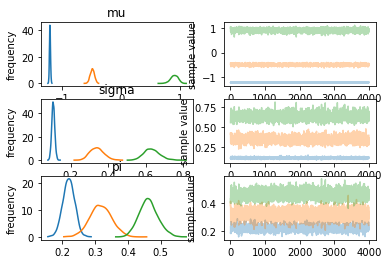

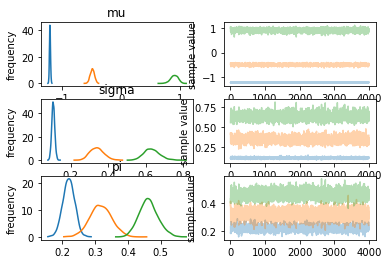

In [10]:
mcmc_result.plot()

In [11]:
normal1_mu = mcmc_result['mu[1]'].mean()
normal2_mu = mcmc_result['mu[2]'].mean()
normal3_mu = mcmc_result['mu[3]'].mean()
normal1_sigma = mcmc_result['sigma[1]'].mean()
normal2_sigma = mcmc_result['sigma[2]'].mean()
normal3_sigma = mcmc_result['sigma[3]'].mean()
pi1 = mcmc_result['pi[1]'].mean()
pi2 = mcmc_result['pi[2]'].mean()
pi3 = mcmc_result['pi[3]'].mean()

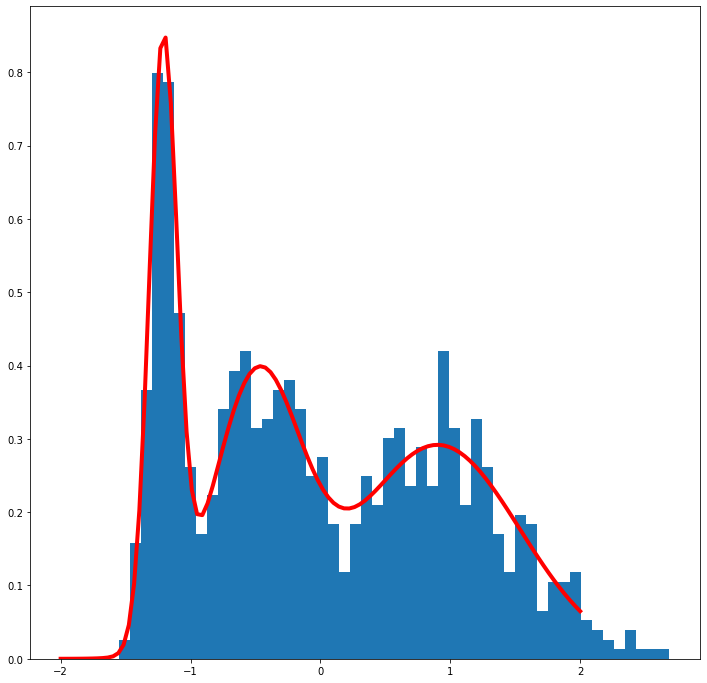

In [12]:
from scipy.stats import norm
fig, axes = plt.subplots(1, figsize = (12, 12))
axes.hist(dfs[:,0], bins=50, density=True)
x=np.linspace(-2,2,100)
ax = axes.plot(x, pi1*norm.pdf(x, loc=normal1_mu,scale=normal1_sigma)+pi2*norm.pdf(x,loc=normal2_mu,scale=normal2_sigma)+pi3*norm.pdf(x,loc=normal3_mu,scale=normal3_sigma), linewidth=4, color='red')